In [55]:
%matplotlib inline

#
# REQUIRED FOR THIS NOTEBOOK:
# pip3 install fastdtw
#

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Read data
data = pd.read_csv('resources/Sales_Transactions_Dataset_Weekly.csv')
# Random subsampling
np.random.seed(42)
idx = np.random.choice(np.arange(len(data)), 200, replace=False)
data = data.iloc[idx]
# Obtain matrices with sales data
sales = data[[c for c in data.columns if c.startswith('W')]].values
# Aggregate by quarter
ql = sales.shape[1] // 4
sales_q = np.vstack([sales[:, i*ql:(i+1)*ql].sum(axis=1) for i in range(4)]).T
# Normalize
sales_q = sales_q / sales_q.sum(axis=0)

In [56]:
%%time
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# Compute pairwise distances
nprods = sales_q.shape[0]
nweeks = sales_q.shape[1]
X = np.zeros((nprods, nprods))
for i in range(nprods):
    si = np.vstack([np.arange(nweeks), sales_q[i, :]]).T
    for j in range(nprods):
        sj = np.vstack([np.arange(nweeks), sales_q[j, :]]).T
        dist, path = fastdtw(si, sj, dist=euclidean)
        X[i, j] = dist

CPU times: user 16.4 s, sys: 208 ms, total: 16.6 s
Wall time: 16.5 s


In [96]:
from sklearn.cluster import DBSCAN

# Build a clustering object
cls = DBSCAN(eps=0.002, min_samples=3, metric='precomputed')
# Train
cls.fit(X)
# Find cluster for each data point
y = cls.labels_
# Print the number of clusters
print('Number of clusters: %d' % len(np.unique(y)))

Number of clusters: 6


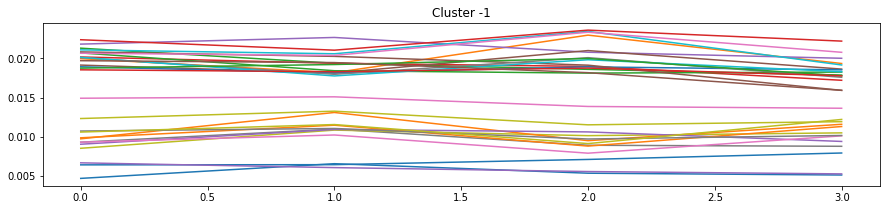

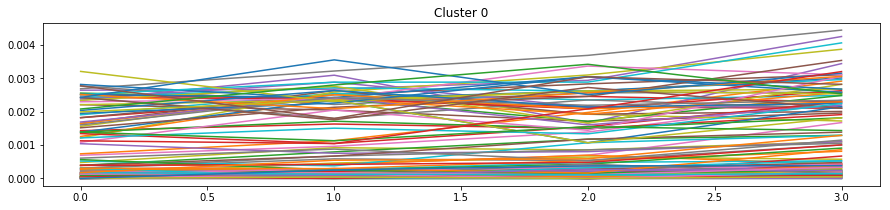

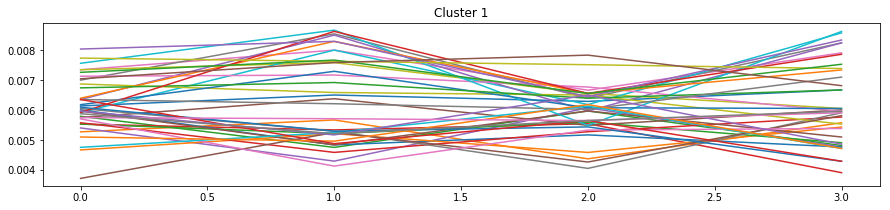

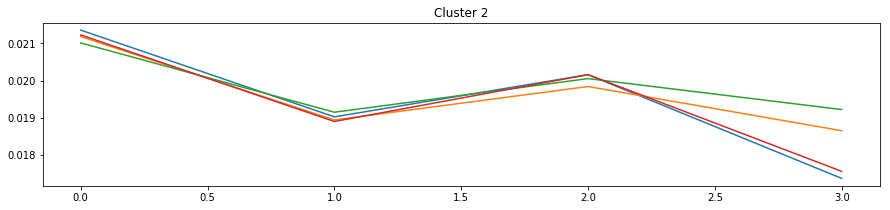

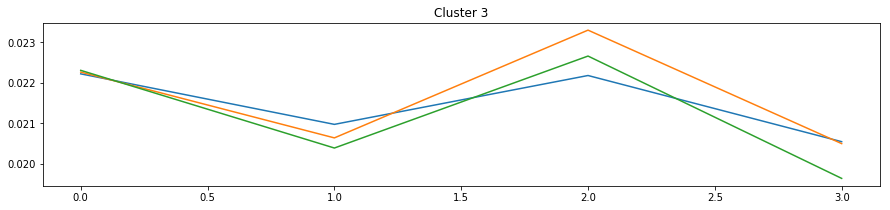

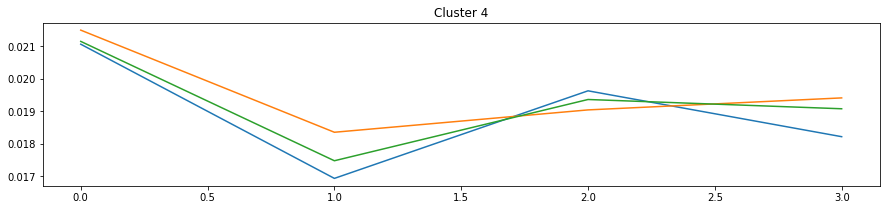

In [97]:
clusters = np.unique(y)

# For each cluster, plot the time series
for c in clusters:
    # Select indices of products in this cluster
    idx = np.arange(len(y))[y == c]
    plt.figure(figsize=(15, 3))
    plt.title('Cluster %d' % c)
    for i in idx:
        plt.plot(np.arange(4), sales_q[i, :])